<h1 style="font-size:30px;">Learning Rate Schedulers</h1>


The learning rate ($\lambda$) is a hyperparameter that determines how big of a step we should take at each iteration when updating the model's parameters during the training.

$$W_{i+1} = W_{i} - \lambda * \frac{\partial L}{\partial W}$$

Learning rate schedulers, also known as learning rate decay or learning rate annealing, are techniques used to adjust the learning rate during the training process of a deep learning model. Instead of using a fixed learning rate throughout the entire training duration, learning rate schedulers modify the learning rate dynamically based on predefined rules or heuristics.


<img src='https://opencv.org/wp-content/uploads/2023/05/c3_w4_LR_scheduler_cover.png' width=100% align='center'><br/>
 

Learning rate schedulers offer a systematic way to change the learning rate, rather than manually tuning it. They're a crucial part of the training process for many deep learning models.

Here are a few reasons why learning rate schedulers are important:

1. **Better Generalization**: In the early stages of training, a large learning rate accelerates learning by allowing the model to quickly converge towards good regions of the parameter space. However, once the model gets closer to the optimal solution, large updates can cause the model to oscillate around the minimum or even diverge. Reducing the learning rate over time can help the model to fine-tune its parameters and achieve better generalization performance.

2. **Faster Convergence**: Initially, when the weights are random, we might be far from the optimal solution. Hence, a larger learning rate can help to make faster progress. As we get closer to the optimal solution, we want to take smaller steps. Thus, reducing the learning rate can help us to converge faster.

3. **Escaping Saddle Points and Local Minima**: At certain points during training, the model might get stuck in suboptimal local minima or saddle points. By periodically increasing the learning rate (as in cyclic learning rate schedules or the "warm restarts" of the CosineAnnealingWarmRestarts scheduler), the model can potentially escape these situations and find better solutions.


In PyTorch, we can add Learning Rate Schedulers using the <a href="https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate" target="_blank">torch.optim.lr_scheduler</a> module. 

In this notebook, we will learn about different learning rate schedulers in PyTorch using the Fashion MNIST dataset. Specifically, we'll take a look at the following learning rate schedulers:

1. Exponential Decay (Exponential LR)
2. Multi-Step LR
3. OneCyle LR
4. CosineAnnealingWarmRestarts 



## Table of Contents

* [1 Training and Dataset Configurations](#1-Training-and-Dataset-Configurations)
* [2 Creating DataLoader Objects](#2-Creating-DataLoader-Objects)
* [3 LeNet5 Model](#3-LeNet5-Model)
* [4 Training and Validation Helper functions](#4-Training-and-Validation-Helper-functions)
* [5 Main function for Training](#5-Main-function-for-Training)
* [6 Training using SGD Momentum without LR Scheduler](#6-Training-using-SGD-Momentum-without-LR-Scheduler)
* [7 Training with Learning Rate Scheduler](#7-Training-with-Learning-Rate-Scheduler)
    * [7.1 Exponential Decay (ExponentialLR)](#7.1-Exponential-Decay-(ExponentialLR))
    * [7.2 Multi-Step LR](#7.2-Multi-Step-LR)
    * [7.3 OneCycleLR](#7.3-OneCycleLR)
    * [7.4 CosineAnnealingWarmRestarts](#7.4-CosineAnnealingWarmRestarts)
* [8 Plotting Accuracy & Loss Curves](#8-Plotting-Accuracy-&-Loss-Curves)
* [9 Conclusion](#9-Conclusion)

In [ ]:
# # Install the following packages and restart the kernel.
# !pip install -qU torchmetrics livelossplot torchinfo tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.8 MB/s eta 0:00:00


In [ ]:
import os
import gc
import math
import warnings
from dataclasses import dataclass
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm
from torchinfo import summary
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

%matplotlib inline
# plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings(action='ignore', category=UserWarning)

We are defining two small helper function for reproducibility and to get the acceleration hardware available.

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

In [ ]:
def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

## 1 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT:      int = 32
    WIDTH:       int = 32
    CHANNELS:    int = 1
    NUM_CLASSES: int = 10
    MEAN:      tuple = (0.2860,)
    STD:       tuple = (0.3530,)
    DATA_ROOT:   str = "data"

    
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 128     
    NUM_EPOCHS:      int = 61     
    LEARNING_RATE: float = 0.1
    NUM_WORKERS:     int = os.cpu_count()

## 2 Fashion MNIST Dataset 


The Fashion MNIST dataset is very similar to MNIST handwritten digits dataset, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3-w4-fashion-MNIST.png' width=700 align='center'><br/>

### 2.1 Creating DataLoader Objects

In [ ]:
def get_data(resize_to=(32, 32), batch_size=32, pin_memory=False, data_root="data", num_workers=0):
    
    # We will only apply pre-processing transformations to the train and valid dataset.
    preprocessing_transforms = transforms.Compose(
        [
            # Resize image.
            transforms.Resize(resize_to),
            
            # Re-scale image tensor values between 0-1. image_tensor /= 255
            transforms.ToTensor(),
            
            # Normalize image by Subtracting mean (0.2860) and divide by variance (0.3530) of the training dataset.
            transforms.Normalize(DatasetConfig.MEAN, DatasetConfig.STD),
        ]
    )

    # Initialize train dataloader
    train_loader = DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=preprocessing_transforms),
        batch_size=batch_size,
        pin_memory=pin_memory,
        shuffle=True,
        num_workers=num_workers,
    )

    # Initialize valid dataloader
    valid_loader = DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=preprocessing_transforms),
        batch_size=batch_size,
        pin_memory=pin_memory,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, valid_loader

### 2.2 Data Visualization

In [ ]:
# This function is used for reversing the Normalization step performed during image preprocessing.
# Note the mean and std values must match the ones used.

def denormalize(tensors, *, mean, std):
    """Denormalizes image tensors using mean and std provided 
    and clip values between 0 and 1"""
    
    for c in range(DatasetConfig.CHANNELS):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

In [ ]:
def visualize_samples(loader):
    plt.figure(figsize=(18, 8))

    for X, y in loader:
        images = denormalize(X, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).squeeze().numpy()
        target = y.numpy()

        for i in range(8):
            plt.subplot(2, 4, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap="gray")
            plt.xlabel(target[i], fontsize=20)

        plt.suptitle("Dataset Samples", fontsize=18)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.show()
        plt.close()

        break

    return

100%|██████████| 26421880/26421880 [00:02<00:00, 12033565.10it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209146.89it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3863883.20it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20642712.23it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



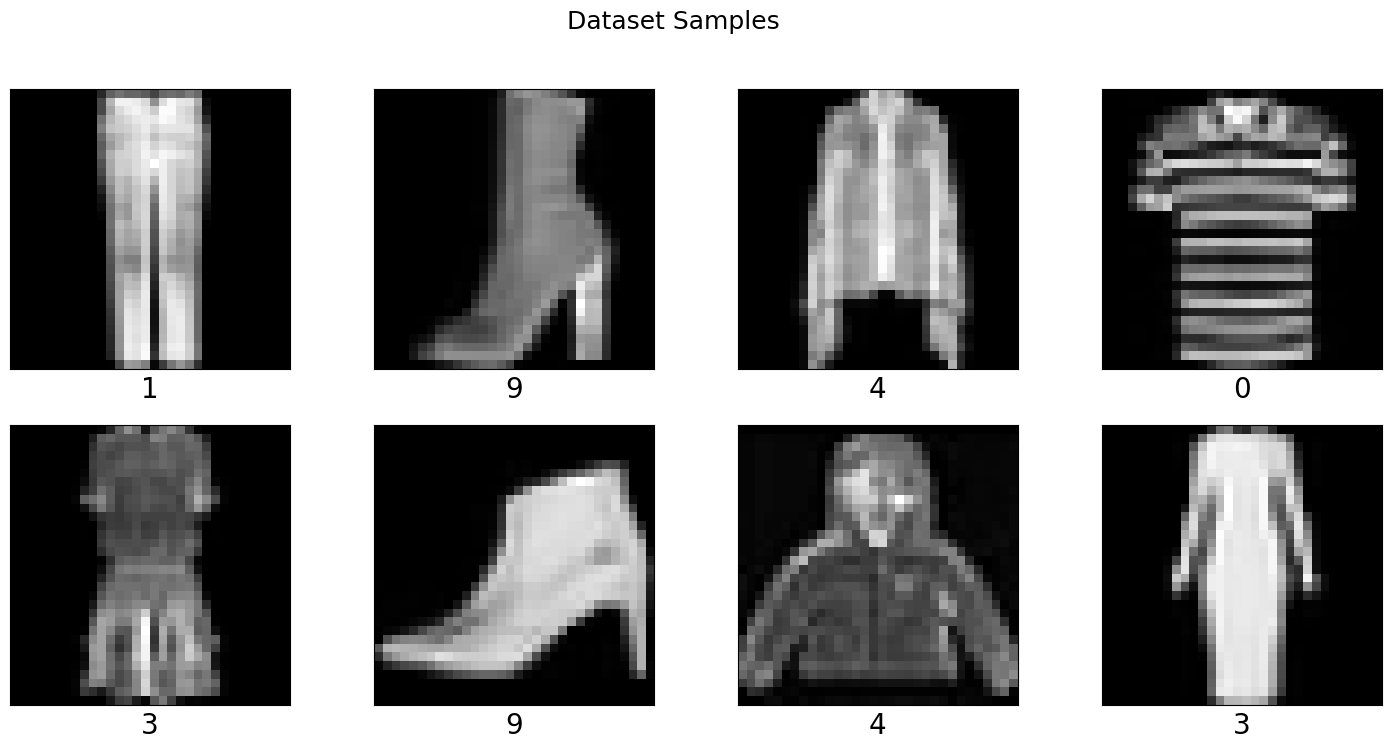

In [ ]:
train_loader, valid_loader = get_data(
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH), 
    batch_size=TrainingConfig.BATCH_SIZE, 
    data_root=DatasetConfig.DATA_ROOT,
)

visualize_samples(train_loader)

## 3 LeNet5 Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=DatasetConfig.CHANNELS, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        # Fully connected layers
        self._head = nn.Sequential(
            # flatten the output of conv layers
            nn.Flatten(),
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=num_classes),
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)

        # apply classification head
        x = self._head(x)
        return x

### 3.1 Print Model Summary

In [ ]:
lenet_model = LeNet5(num_classes=DatasetConfig.NUM_CLASSES)

summary(lenet_model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 6, 28, 28]            156
│    └─ReLU: 2-2                         [1, 6, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 6, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 16, 10, 10]           2,416
│    └─ReLU: 2-5                         [1, 16, 10, 10]           --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-7                      [1, 400]                  --
│    └─Linear: 2-8                       [1, 120]                  48,120
│    └─ReLU: 2-9                         [1, 120]                  --
│    └─Linear: 2-10                      [1, 84]                   10,164
│  

## 4 Training and Validation Helper functions

Next, we are defining the `train_one_epoch(...)` and `validate(...)` helper functions.

Both the `train_one_epoch(...)` and `validate(...)` functions utilize the `tqdm` package to display a progress bar during training and evaluation stages, which visually represents the progress of the training and evaluation loops.
The progress bar displays relevant information such as the running loss, accuracy, and the updated learning rate.

The `train_one_epoch(...)` takes in an additional `scheduler` parameter which refers to the learning rate scheduler object. This parameter is used to pass any LR scheduler that performs a per-batch update. For eg. as we'll see later in the notebook, `OneCycleLR` and `CosineAnnealingWarmRestarts` update learning rates after each batch updates.


In [ ]:
def train_one_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int,
    scheduler: torch.optim.lr_scheduler=None,
):
    # Set model in training mode.
    model.train()

    loss_record = MeanMetric()
    acc_record  = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(train_loader)
    
    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch_idx}/{total_epochs}")
          
        for data, target in train_loader:
            tq.update(1)
            
            # Send data and target to GPU device if available.
            data   = data.to(device)
            target = target.to(device)

            # Record current learning rate. 
            lr = optimizer.param_groups[0]['lr'] # As all model parameters were passed during optimizer initialization, 
                                                 # the all belong to param_group[0]

            # Reset parameters gradient to zero.
            optimizer.zero_grad()

            # Perform forward pass through the model.
            logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Find gradients w.r.t training parameters.
            loss.backward()

            # Update parameters using gradients.
            optimizer.step()
            
            if scheduler: # Scheduler step/ update learning rate.
                scheduler.step()
                
            # Record loss.
            loss_record.update(loss.detach().cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy.
            acc_record.update(pred.cpu(), target.cpu())

            # Update progress bar description with running mean and accuracy values.
            tq.set_postfix_str(s=f"LR: {lr}, Loss: {loss_record.compute():.4f}, Acc: {acc_record.compute():.4f}")
    
    # Get final loss and accuracy. 
    # The values are the same as the one displayed for the final iteration. 
    epoch_loss = loss_record.compute()
    epoch_acc  = acc_record.compute()

    return epoch_loss.item(), epoch_acc.item()

In [ ]:
def validate(
    model: nn.Module,
    valid_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int
):

    # Set model in evaluation mode.
    model.eval()
    
    loss_record = MeanMetric()
    acc_record = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(valid_loader)
    
    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")
          
        for data, target in valid_loader:
            tq.update(1)
            
            # Send data and target to GPU device if available.
            data     = data.to(device)
            target = target.to(device)
            
            with torch.no_grad():
                # Perform forward pass through the model.
                logits = model(data)
                
            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Record loss.
            loss_record.update(loss.cpu(), weight=data.shape[0])
            
            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1) 
                            
            # Calculate and record accuracy
            acc_record.update(pred.cpu(), target.cpu())

        valid_epoch_loss = loss_record.compute()
        valid_epoch_acc  = acc_record.compute()

        # Update progress bar description to display epoch log.
        tq.set_postfix_str(s=f"Loss: {valid_epoch_loss:.4f}, Acc: {valid_epoch_acc:.4f}")
    
    return valid_epoch_loss.item(), valid_epoch_acc.item()

## 5 Main function for Training

Next, we are defining a `main(...)` function that contains all the necessary code for training the model.

In [ ]:
def main(model, optimizer, device, pin_memory=False, scheduler_dict=None):
    
    # Intialize train and valid dataloaders.
    train_loader, valid_loader = get_data(
        resize_to   = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
        batch_size  = TrainingConfig.BATCH_SIZE,
        pin_memory  = pin_memory,
        data_root   = DatasetConfig.DATA_ROOT,
        num_workers = TrainingConfig.NUM_WORKERS,
    )
    
    # Accumulate train and valid per epoch metric. 
    epoch_train_acc = []
    epoch_valid_acc = []

    epoch_train_loss = []
    epoch_valid_loss = []
    
    total_epochs = TrainingConfig.NUM_EPOCHS
    
    # Unpack the scheduler_dict if scheduler is used.
    if scheduler_dict:
        scheduler = scheduler_dict['scheduler']
        update_per_epoch = scheduler_dict['update_per_epoch']
    else:
        scheduler = None
        update_per_epoch = False

    # # # Compile Model.
    # # Uncomment this line if you are using PyTorch 2.0.
    # # Sometimes compilation can also lead to error, do a test run with few epochs
    # # to ensure the code runs without any error. If it doesn't turn off compilation. 
    # model = torch.compile(model)
        
    for epoch in range(total_epochs):
        
        # Clear display.
        clear_output()
        
        # Train for one epoch.
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device, 
                                                DatasetConfig.NUM_CLASSES, epoch+1, total_epochs,
                                                scheduler=None if update_per_epoch else scheduler,
                                                )
        
        # Perform validation run. 
        valid_loss, valid_acc = validate(model, valid_loader, device, DatasetConfig.NUM_CLASSES, epoch+1, total_epochs)    
        
        # Collect loss and accuracy
        epoch_train_loss.append(train_loss)
        epoch_valid_loss.append(valid_loss)
        
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
    
        # Update learning rate if scheduler works on per-epoch basis.
        if scheduler and update_per_epoch:
            scheduler.step()

    # Cleanup
    del model
    del optimizer
    del train_loader
    del valid_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return epoch_train_acc, epoch_train_loss, epoch_valid_acc, epoch_valid_loss

For all runs, we will use the same model and optimizer configuration. To avoid any redundant LOCs, we will wrap the model and optimizer initialization code inside a simple helper function.

In [ ]:
def initialize_model_optimizer(device, momentum=0.9):
    # Set Randomization seeds.
    seed_everything(41)

    # Initialize Model
    model = LeNet5(num_classes=DatasetConfig.NUM_CLASSES)
    model.to(device)

    # Intiaize Optimizer.
    optimizer = optim.SGD(model.parameters(), 
                          lr=TrainingConfig.LEARNING_RATE, 
                          momentum=momentum
                          )
    
    return model, optimizer

## 6 Training using SGD Momentum without LR Scheduler

In [ ]:
# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Get Model and Optimizer.
model, optimizer = initialize_model_optimizer(DEVICE, momentum=0.9)

# Start Training.
train_acc, train_loss, valid_acc, valid_loss = main(model, 
                                                    optimizer, 
                                                    DEVICE, 
                                                    pin_memory=GPU_AVAILABLE, 
                                                    scheduler_dict=None
                                                   )

Valid :: Epoch: 61/61: 100%|###################################| 79/79 [00:00<00:00, 84.11it/s, Loss: 2.3027, Acc: 0.1006]


## 7 Training with Learning Rate Scheduler

### 7.1 Exponential Decay (ExponentialLR)

$$\normalsize{\alpha = \alpha_0 * \gamma^n}$$

where, 

$\alpha_0 = \text{inital learning rate}$

$n = \text{epoch}$

$\gamma = \text{decay_rate}$

The learning rate is computed as:

---

***PyTorch Class***

```python
from torch.optim.lr_scheduler import ExponentialLR

scheduler = ExponentialLR(optimizer, gamma, last_epoch=-1, verbose=False)
```

***Parameters:***

* `optimizer` (Optimizer) – Wrapped optimizer.

* `gamma` (float) – Multiplicative factor of learning rate decay.

* `last_epoch` (int) – The index of last epoch. Default: `-1`.

* `verbose` (bool) - If True, prints a message to stdout for each update. Default: `False`.

For more details, please visit the documentation page: <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR" target="_blank">[DOCS]</a>

#### 7.1.1 Dummy Use & Plotting LR curve

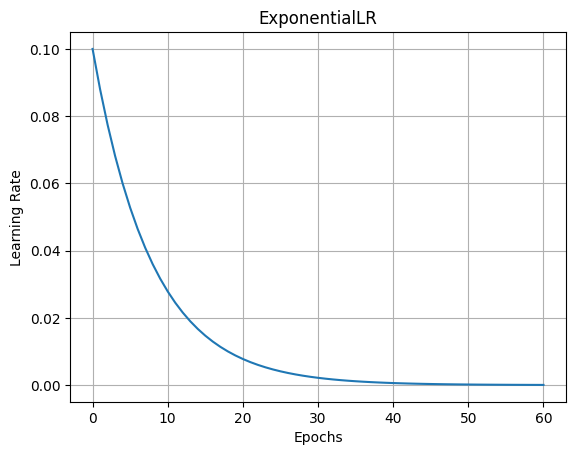

First LR: 0.1, Last LR: 4.666167548727584e-05


In [ ]:
# Dummy model.
model = nn.Linear(3, 2)

# Intiaize dummy Optimizer.
optimizer = optim.SGD(model.parameters(), lr=TrainingConfig.LEARNING_RATE, momentum=0.9)

# Initialize dummy learning rate scheduler.
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.88, verbose=False) # Adjust gamma according to the number of epochs.

lrs = [] # Record intermediate LRs.

for i in range(TrainingConfig.NUM_EPOCHS):
    lrs.append(scheduler.get_last_lr()[-1]) # Get Current LR used for parameter updates.

    # optimizer.step()
    scheduler.step() # Update Learning Rate
 

plt.plot(lrs) # Plot learning rate curve.
plt.grid(True)
plt.title("ExponentialLR")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.show();

print(f"First LR: {lrs[0]}, Last LR: {lrs[-1]}")

#### 7.1.2 Training

In [ ]:
# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Get Model and Optimizer.
model, optimizer = initialize_model_optimizer(DEVICE, momentum=0.9)

# Initialize learning rate scheduler.
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.88, verbose=False)

scheduler_dict = {
    "scheduler": scheduler,
    "update_per_epoch": True,
}

# Start training.
train_acc_ed, train_loss_ed, valid_acc_ed, valid_loss_ed = main(model, 
                                                                optimizer, 
                                                                DEVICE, 
                                                                pin_memory=GPU_AVAILABLE, 
                                                                scheduler_dict=scheduler_dict
                                                               )

Train :: Epoch: 61/61: 100%|#| 469/469 [00:04<00:00, 113.23it/s, Last LR: 4.666167548727584e-05, Loss: 0.0837, Acc: 0.9708
Valid :: Epoch: 61/61: 100%|###################################| 79/79 [00:00<00:00, 82.62it/s, Loss: 0.4110, Acc: 0.8977]


### 7.2 Multi-Step LR

1. A multi-step learning rate scheduler divides the training process into multiple steps and allows for making learning rate adjustments at predefined milestones or steps during the training process.

2. Typically, the learning rate is decreased at specific epochs or after a certain number of iterations or a milestone is reached. 

3. By using a multi-step learning rate scheduler, you have more control over the learning rate throughout the training process.
 
In PyTorch, you can use the `torch.optim.lr_scheduler.MultiStepLR` class to implement a multi-step learning rate scheduler. This scheduler takes a list of milestones, which represent the epochs or iterations at which the learning rate should be adjusted, and a gamma value, which determines the factor by which the learning rate is decreased.

---

***PyTorch Class***

```python
from torch.optim.lr_scheduler import MultiStepLR

scheduler = MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1, verbose=False)
```

***Parameters:***

* `optimizer` (Optimizer) – Wrapped optimizer.

* `milestones` (list) – List of epoch indices. Must be increasing.

* `gamma` (float) – Multiplicative factor of learning rate decay. Default: `0.1`.

* `last_epoch` (int) – The index of last epoch. Default: `-1`.

* `verbose` (bool) – If True, prints a message to stdout for each update. Default: `False`.

For more details, please visit the documentation page: <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#multisteplr" target="_blank">[DOCS]</a>

#### 7.2.1 Dummy Use & Plotting LR curve

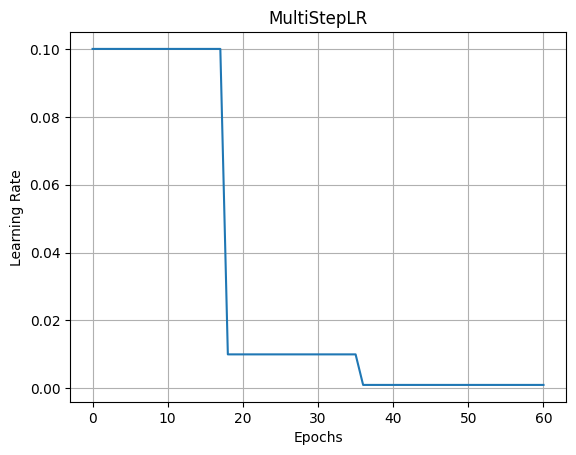

First LR: 0.1, Last LR: 0.0010000000000000002


In [ ]:
# Dummy model.
model = nn.Linear(3, 2)

# Intiaize dummy Optimizer.
optimizer = optim.SGD(model.parameters(), lr=TrainingConfig.LEARNING_RATE, momentum=0.9) 

# Initialize dummy learning rate scheduler.
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[18, 36], gamma=0.1) # Adjust milestones and gamma accordingly.

lrs = [] # Record intermediate LRs.

for i in range(TrainingConfig.NUM_EPOCHS):
    lrs.append(scheduler.get_last_lr()[-1]) # Get Current LR used for parameter updates.

    # optimizer.step()
    scheduler.step() # Update Learning Rate


plt.plot(lrs) # Plot learning rate curve.
plt.grid(True)
plt.title("MultiStepLR")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.show();

print(f"First LR: {lrs[0]}, Last LR: {lrs[-1]}")

In this example, the learning rate will be decreased by a factor of `0.1` at epochs 18 and 36. You can adjust the milestones and the gamma value according to your specific training needs.

#### 7.2.2 Training

In [ ]:
# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Get Model and Optimizer.
model, optimizer = initialize_model_optimizer(DEVICE, momentum=0.9)

# Initialize learning rate scheduler.
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[18, 36], gamma=0.1) # Adjust milestones and gamma accordingly.
 
scheduler_dict = {
    "scheduler": scheduler,
    "update_per_epoch": True,
}

train_acc_ms, train_loss_ms, valid_acc_ms, valid_loss_ms = main(model, 
                                                                optimizer, 
                                                                DEVICE, 
                                                                pin_memory=GPU_AVAILABLE, 
                                                                scheduler_dict=scheduler_dict
                                                               )

Train :: Epoch: 61/61: 100%|#| 469/469 [00:04<00:00, 109.02it/s, Last LR: 0.0010000000000000002, Loss: 0.1030, Acc: 0.9599
Valid :: Epoch: 61/61: 100%|###################################| 79/79 [00:00<00:00, 82.11it/s, Loss: 0.4041, Acc: 0.9011]


### 7.3 OneCycleLR 

1. The OneCycle learning rate scheduler is a technique to dynamically adjust the learning rate during training. It is based on the idea of using cyclical learning rates, where the learning rate varies between a minimum value and a maximum value within a single cycle.

2. The OneCycle learning rate scheduler adjusts the learning rate based on a cyclical schedule, typically consisting of three phases:

   1. Increasing the learning rate
   2. Decreasing the learning rate
   3. Then further decreasing it towards the end of training. 
  
3. This cycling behavior is designed to help the model explore different regions of the loss landscape and converge faster.

***From documentation:***

> Sets the learning rate of each parameter group according to the 1cycle learning rate policy. The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate. This policy was initially described in the paper <a href="https://arxiv.org/abs/1708.07120" target="_blank">Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates</a>.


The 1cycle learning rate policy **changes the learning rate after every batch**. `.step()` should be called after a batch has been used for training.


Note also that the total number of steps in the cycle can be determined in one of two ways (listed in order of precedence):

1. A value for total_steps is explicitly provided.

2. A number of epochs (epochs) and a number of steps per epoch (steps_per_epoch) are provided. In this case, the number of total steps is inferred by `total_steps = epochs * steps_per_epoch`

You must either provide a value for `total_steps` or provide a value for both `epochs` and `steps_per_epoch`.

***PyTorch Class***

```python
from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(optimizer, max_lr, total_steps=None, epochs=None, steps_per_epoch=None, anneal_strategy='cos', 
                       div_factor=25.0, final_div_factor=10000.0, pct_start=0.3, cycle_momentum=True, 
                       base_momentum=0.85, max_momentum=0.95, three_phase=False, last_epoch=-1, verbose=False
                      )
```


***Parameters*** 

Most of the default values work well and are rarely touched, the ones that we need to check and update are as follows:


* `optimizer` (Optimizer) – Wrapped optimizer.

* `max_lr` (float or list) – Upper learning rate boundaries in the cycle for each parameter group.

* `total_steps` (int) – The total number of steps in the cycle. Note that if a value is not provided here, then it must be inferred by providing a value for epochs and steps_per_epoch. Default: `None`

* `epochs` (int) – The number of epochs to train for. This is used along with steps_per_epoch in order to infer the total number of steps in the cycle if a value for total_steps is not provided. Default: `None`

* `steps_per_epoch` (int) – The number of steps per epoch to train for. This is used along with epochs in order to infer the total number of steps in the cycle if a value for total_steps is not provided. Default: `None`

* `div_factor` (float) – Determines the initial learning rate via `initial_lr = max_lr/div_factor`. Default: `25`

* `final_div_factor` (float) – Determines the minimum learning rate via `min_lr = initial_lr/final_div_factor`. Default: `1e4`

For more details, please visit the documentation page: <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#onecyclelr" target="_blank">[DOCS]</a>

#### 7.3.1 Dummy Use & Plotting LR curve

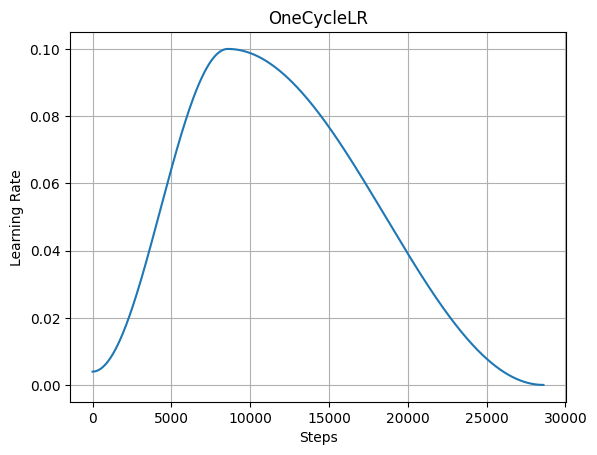

First LR: 0.0040000000000000036, Last LR: 4e-05


In [ ]:
# Dummy model.
model = nn.Linear(3, 2)

# Intiaize dummy Optimizer.
optimizer = optim.SGD(model.parameters(), lr=TrainingConfig.LEARNING_RATE, momentum=0.9) 

# Calculate total training steps.
steps_per_epoch = len(train_loader) # Number of batches.
total_training_steps = TrainingConfig.NUM_EPOCHS * steps_per_epoch

# Initialize dummy learning rate scheduler.
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=TrainingConfig.LEARNING_RATE, 
                                    total_steps=total_training_steps, final_div_factor=1e2)

lrs = [] # Record intermediate LRs.
    
for epoch in range(TrainingConfig.NUM_EPOCHS):
    for _ in range(steps_per_epoch):
        lrs.append(scheduler.get_last_lr()[-1]) # Get Current LR used for parameter updates.

        # optimizer.step()
        scheduler.step() # Update Learning Rate


plt.plot(lrs) # Plot learning rate curve.
plt.grid(True)
plt.title("OneCycleLR")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show();

print(f"First LR: {lrs[0]}, Last LR: {lrs[-1]}")

The initial learning rate is set to `1e-1 / 25 = 0.004` and the final learning rate is `0.004 / 1e2 = 0.00004 = 4e-5`

#### 7.3.2 Training

In [ ]:
# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Get Model and Optimizer.
model, optimizer = initialize_model_optimizer(DEVICE, momentum=0.9)

# Calculate total training steps.
steps_per_epoch = len(train_loader)
total_training_steps = TrainingConfig.NUM_EPOCHS * steps_per_epoch

# Initialize learning rate scheduler.
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=TrainingConfig.LEARNING_RATE, 
                                    total_steps=total_training_steps, final_div_factor=1e2)
 
scheduler_dict = {
    "scheduler": scheduler,
    "update_per_epoch": False,
}

train_acc_oc, train_loss_oc, valid_acc_oc, valid_loss_oc = main(model, 
                                                                optimizer, 
                                                                DEVICE, 
                                                                pin_memory=GPU_AVAILABLE, 
                                                                scheduler_dict=scheduler_dict
                                                               )

Valid :: Epoch: 61/61: 100%|###################################| 79/79 [00:00<00:00, 81.72it/s, Loss: 0.9659, Acc: 0.8994]


### 7.4 CosineAnnealingWarmRestarts

`CosineAnnealingWarmRestarts` is a learning rate scheduler based on the idea of "cosine annealing", where the learning rate decreases according to a cosine function, but instead of doing this once, it does it in a series of cycles. This means that the learning rate starts high, decreases over time, then restarts at a high value again, over and over. 

The "Warm Restarts" part means that the learning rate doesn't just suddenly jump back to a high value, but it's adjusted smoothly. The idea is to restart the learning rate periodically, allowing the model to explore the parameter space more thoroughly and potentially find better solutions. This technique can help in finding global optima by escaping local optima, and it can also lead to faster convergence.

This method was proposed by Loshchilov & Hutter in the paper: <a href="https://arxiv.org/abs/1608.03983" target="_blank">"SGDR: Stochastic Gradient Descent with Warm Restarts"</a>. 

***From documentation:***

> Set the learning rate of each parameter group using a cosine annealing schedule, where $\normalsize{\eta_{max}}$ is set to the initial lr, $\normalsize{T_{cur}}$ is the number of epochs since the last restart and $\normalsize{T_{i}}$ is the number of epochs between two warm restarts in SGDR:

$$\large{\eta_{t} = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min} \left( 1 + cos\left(\frac{T_{cur}}{T_{i}} \pi) \right) \right) }$$


The scheduler's `.step()` should be called after a batch has been used for training.

---

***PyTorch Class:***

```python
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1, verbose=False)
```

***Parameters:***

* `optimizer` (Optimizer) – Wrapped optimizer.

* `T_0` (int) – Number of iterations for the first restart.

* `T_mult` (int, optional) – A factor increases $\normalsize{T_{i}}$ after a restart. Default: `1`.

* `eta_min` (float, optional) – Minimum learning rate. Default: `0`.

* `last_epoch` (int, optional) – The index of last epoch. Default: `-1`.

* `verbose` (bool) – If True, prints a message to stdout for each update. Default: `False`.



For more details, please visit the documentation page: <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html#cosineannealingwarmrestarts" target="_blank">[DOCS]</a>

#### 7.4.1 Dummy Use & Plotting LR curve

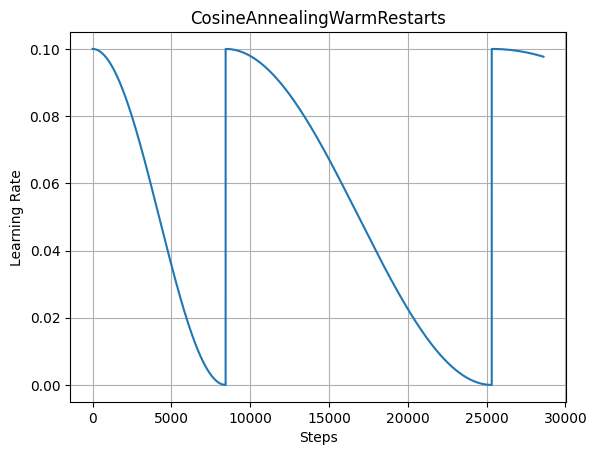

First LR: 0.1, Last LR: 0.09768724844610599, Min LR: 1.0086554296550847e-07


In [ ]:
# Dummy model.
model = nn.Linear(3, 2)

# Intiaize dummy Optimizer.
optimizer = optim.SGD(model.parameters(), lr=TrainingConfig.LEARNING_RATE, momentum=0.9) 

# Calculate total training steps.
steps_per_epoch = len(train_loader)
total_training_steps = TrainingConfig.NUM_EPOCHS * steps_per_epoch

# First restart at the end of 18th epoch.
t_0 = steps_per_epoch * 18 # We can also set it to restart after some specified steps. 
t_mult = 2

# Initialize dummy learning rate scheduler.
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=t_0, T_mult=t_mult, eta_min=1e-7)

lrs = [] # Record intermediate LRs.
    
for epoch in range(TrainingConfig.NUM_EPOCHS):
    for _ in range(steps_per_epoch):
        lrs.append(scheduler.get_last_lr()[-1]) # Get Current LR used for parameter updates.

        # optimizer.step()
        scheduler.step() # Update Learning Rate


plt.plot(lrs) # Plot learning rate curve.
plt.grid(True)
plt.title("CosineAnnealingWarmRestarts")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show();

print(f"First LR: {lrs[0]}, Last LR: {lrs[-1]}, Min LR: {min(lrs)}")

#### 7.4.2 Training

In [ ]:
# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Get Model and Optimizer.
model, optimizer = initialize_model_optimizer(DEVICE, momentum=0.9)

# Set Scheduler parameters.
steps_per_epoch = len(train_loader)
t_0 = steps_per_epoch * 18  
t_mult = 2

# Initialize Scheduler.
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=t_0, T_mult=t_mult, eta_min=1e-7)

scheduler_dict = {
    "scheduler": scheduler,
    "update_per_epoch": False,
}

train_acc_cw, train_loss_cw, valid_acc_cw, valid_loss_cw = main(model, 
                                                                optimizer, 
                                                                DEVICE, 
                                                                pin_memory=GPU_AVAILABLE, 
                                                                scheduler_dict=scheduler_dict
                                                               )

Valid :: Epoch: 61/61: 100%|###################################| 79/79 [00:00<00:00, 81.98it/s, Loss: 0.4336, Acc: 0.8804]


## 8 Plotting Accuracy & Loss Curves

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(18, 5))
    # ax.set_facecolor("white")

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel + " per Epoch")
    plt.xlim([0, TrainingConfig.NUM_EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.tight_layout()
    plt.savefig(f"{ylabel}.png")
    plt.show()
    plt.close()

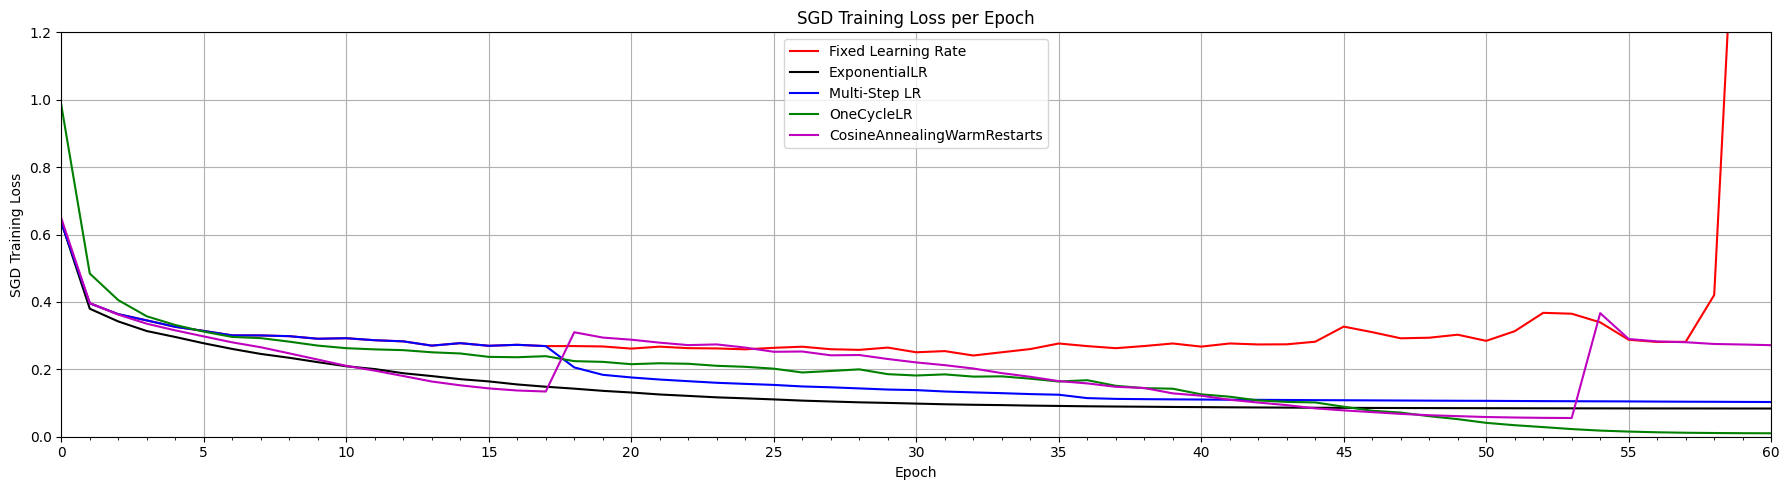

In [ ]:
plot_results(
    [train_loss, train_loss_ed, train_loss_ms, train_loss_oc, train_loss_cw],
    ylabel="SGD Training Loss",
    ylim=[0.0, 1.2],
    metric_name=["Fixed Learning Rate", "ExponentialLR", "Multi-Step LR", "OneCycleLR", "CosineAnnealingWarmRestarts"],
    color=["r", "k", "b", "g", "m"],
)

The initial learning rate was kept at a higher value (`0.1`) which is typically used as a starting point when training models from scratch. 

Some observations from the above plot:

1. Training with SGD + momentum with no LR scheduler gives the worst results, and the model diverges during the final epochs. 
2. ExponentialLR, as expected, gradually decreases the LR, which results in a smooth loss curve. 
3. There's a sudden drop in LR and loss value when a milestone is reached for Multi-Step LR. 
4. OneCycleLr starts with a higher loss than the rest but achieves the lowest loss by the end of training.
5. CosineAnnealingWarmRestarts has a similar behavior as ExponentialLR wherein the loss decreases smoothly for some epochs and shoots up when a restart occurs.

Overall, on this dataset, with the model, the OneCycleLr policy performs the best on the training loss. 

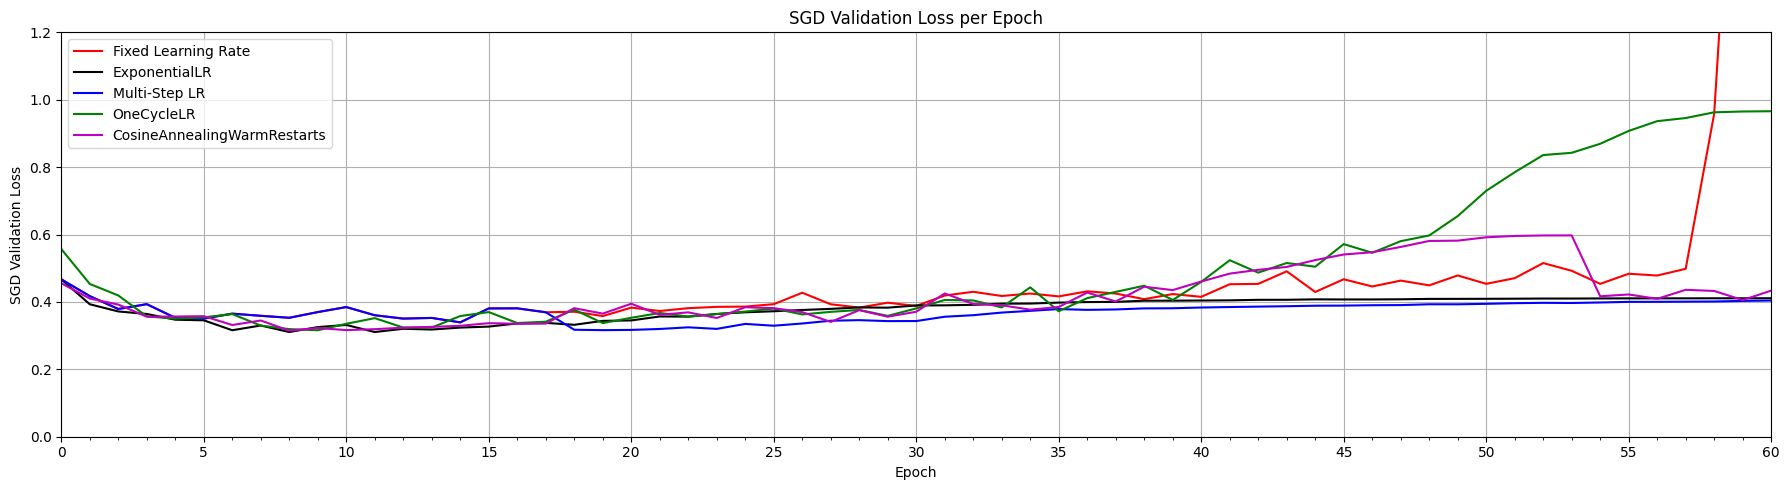

In [ ]:
plot_results(
    [valid_loss, valid_loss_ed, valid_loss_ms, valid_loss_oc, valid_loss_cw],
    ylabel="SGD Validation Loss",
    ylim=[0.0, 1.2],
    metric_name=["Fixed Learning Rate", "ExponentialLR", "Multi-Step LR", "OneCycleLR", "CosineAnnealingWarmRestarts"],
    color=["r", "k", "b", "g", "m"],
)

On the validation set, the model tends to overfit after 15-20 epochs, and every run seems to have achieved an approximately similar minimum loss.

It should be noted that validation loss itself is not typically used directly for choosing a learning rate scheduler. The learning rate scheduler is primarily chosen based on the dynamics of the training process rather than the validation loss.

The learning rate scheduler adjusts the learning rate during training to optimize the model's convergence. It aims to improve the training process and ensure the model reaches an optimal solution rather than optimizing the validation loss.

However, it's worth noting that the validation loss can be used indirectly to evaluate the effectiveness of the chosen learning rate scheduler. By monitoring the validation loss over time, you can assess if the scheduler is helping the model generalize well to unseen data and prevent overfitting. If the chosen scheduler is not producing satisfactory validation loss results, you may need to experiment with different schedulers or adjust the hyperparameters associated with the scheduler (e.g., decay factor, milestones) to find a better configuration.

Let's also take a look at the training and validation accuracy.

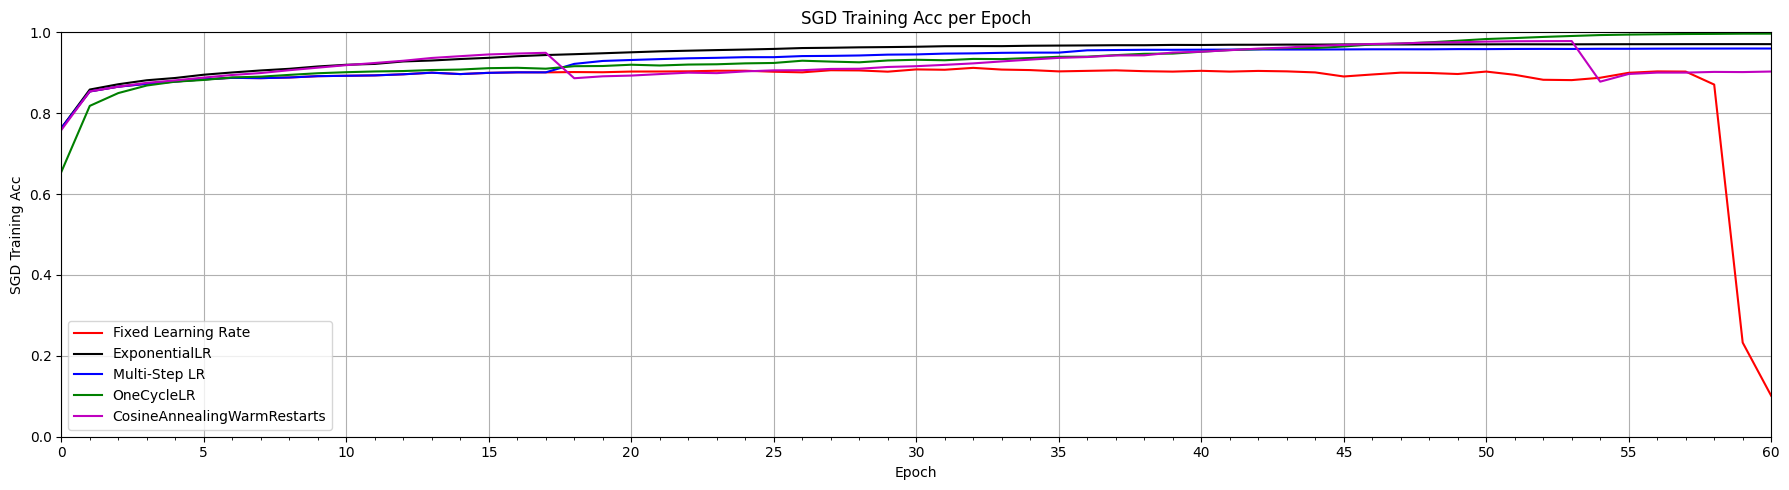

In [ ]:
plot_results(
    [train_acc, train_acc_ed, train_acc_ms, train_acc_oc, train_acc_cw],
    ylabel="SGD Training Acc",
    ylim=[0.0, 1.0],
    metric_name=["Fixed Learning Rate", "ExponentialLR", "Multi-Step LR", "OneCycleLR", "CosineAnnealingWarmRestarts"],
    color=["r", "k", "b", "g", "m"],
)

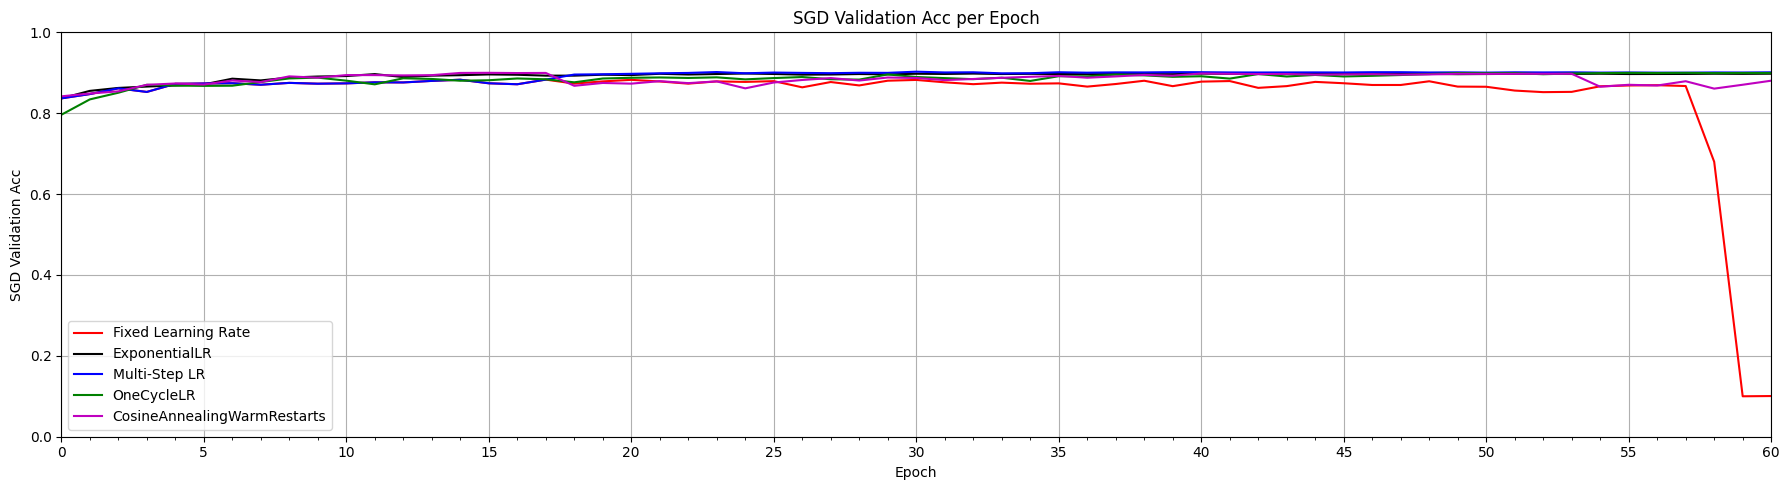

In [ ]:
plot_results(
    [valid_acc, valid_acc_ed, valid_acc_ms, valid_acc_oc, valid_acc_cw],
    ylabel="SGD Validation Acc",
    ylim=[0.0, 1.0],
    metric_name=["Fixed Learning Rate", "ExponentialLR", "Multi-Step LR", "OneCycleLR", "CosineAnnealingWarmRestarts"],
    color=["r", "k", "b", "g", "m"],
)

## 9 Conclusion

In this notebook, we explored the use of four different learning rate schedulers. We found that they can dramatically improve the convergence rate of the model. 

As is often the case in deep learning, experimentation is often required and recommended to confirm which settings work best for your problem. Selecting an appropriate optimizer and learning rate scheduler can make a big difference in the amount of time required to train your model. It can sometimes lead to higher accuracy as well. 

Other schedulers, such as CosineAnnealingLR, CyclicLR, LinearLR, etc., are also available in PyTorch. As an exercise, you can plot the learning rate curves to get a general idea of how they work.